## Training Data

### Getting Data

In [1]:
%load_ext autoreload
%autoreload 2


In [6]:
# Getting the data
from glob import glob

imgs = glob('dataset/**/*.png', recursive=True)
cars = []
not_cars = []
for img in imgs:
    if 'non-vehicles' in img:
        not_cars.append(img)
    else:
        cars.append(img)
        

### Getting Features

In [2]:
from tqdm import tqdm
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import numpy as np

In [4]:
# colorwise histogram feature
def color_hist(img, nbins=32):
    channel1 = np.histogram(img[:, :, 0], bins=nbins)
    channel2 = np.histogram(img[:, :, 1], bins=nbins)
    channel3 = np.histogram(img[:, :, 2], bins=nbins)
    return np.concatenate((channel1[0], channel2[0], channel3[0]))

# spatial features
def bin_spatial(img, size=(32, 32)):
    c1 = cv2.resize(img[:, :, 0], size).ravel()
    c2 = cv2.resize(img[:, :, 1], size).ravel()
    c3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack((c1, c2, c3))

# convenience method for hog
def get_hog(img, orientation, pix_per_cell, cell_per_block, feature_vec=True):
    return hog(img, orientations=orientation, pixels_per_cell=(pix_per_cell, pix_per_cell),
              cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
              visualise=True, feature_vector=feature_vec)

# used for training
def extract_features(imgs, spatial_size=(32, 32), hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
        
        hog_features = []
        for channel in range(feature_image.shape[2]):
            feat, img = get_hog(feature_image[:, :, channel],
                                                 orient, pix_per_cell, cell_per_block,
                                                 feature_vec=True)
            hog_features.append(feat)
        hog_features = np.ravel(hog_features)
        
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



In [16]:
#car_features = extract_features(cars)

  0%|          | 0/8792 [00:00<?, ?it/s]/Users/alex/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 8792/8792 [06:35<00:00, 20.64it/s]

CPU times: user 6min 26s, sys: 8.41 s, total: 6min 34s
Wall time: 6min 35s


In [17]:
#not_car_features = extract_features(not_cars)

  0%|          | 0/8968 [00:00<?, ?it/s]/Users/alex/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 8968/8968 [06:44<00:00, 17.77it/s]


### Normalizing features

In [19]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))
raw_X = np.vstack((car_features, not_car_features)).astype(np.float64)                        

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(raw_X)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

### SVC Training

In [22]:
from sklearn.svm import LinearSVC
from sklearn.externals import joblib

svc = LinearSVC()
%time svc.fit(X_train, y_train)

CPU times: user 15.6 s, sys: 830 ms, total: 16.4 s
Wall time: 16.9 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [23]:
print('Test Score: ', svc.score(X_test, y_test))

Test Score:  0.991216216216


In [24]:
# saving the data
joblib.dump(svc, 'svc_pickle.pkl') 

['svc_pickle.pkl']

In [40]:
joblib.dump(scaler, 'scaler.pkl') 

['scaler.pkl']

###  Loading the SVC

In [1]:
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import numpy as np
import skvideo.io
from scipy.ndimage.measurements import label

loaded_svc = joblib.load('svc_pickle.pkl')
loaded_scaler = joblib.load('scaler.pkl') 

In [2]:
# used for inference, takes an image & draws boxes around the detected cars
# reuse scaler for inference
# includes sliding window technique
def mark_cars(img, y_regions_and_scales, svc, scaler,  
              orient=9, pix_per_cell=8, 
              cell_per_block=2, 
              spatial_size=(32, 32),
              hist_bins=32, display=False):
    output_img = None
    # 2d heatmap
    heatmap = np.zeros(img.shape[:2])
    
    if display:
        output_img = np.copy(img)
        
    img = img.astype(np.float32) / 255
    
    for (y_region, scale) in y_regions_and_scales:
        img_region = img[y_region[0]:y_region[1], :, :]
        color_transformed = cv2.cvtColor(img_region, cv2.COLOR_RGB2YCrCb)
        img_shape = color_transformed.shape

        color_transformed = cv2.resize(color_transformed, 
                                       (int(img_shape[1]//scale), 
                                        int(img_shape[0]//scale)))

        ch1 = color_transformed[:, :, 0]
        ch2 = color_transformed[:, :, 1]
        ch3 = color_transformed[:, :, 2]

        num_x_blocks = (ch1.shape[1] // pix_per_cell) - 1
        num_y_blocks = (ch1.shape[0] // pix_per_cell) - 1

        pixels_per_window = 64
        num_blocks_per_window = (pixels_per_window // pix_per_cell) - 1
        cells_per_step = 2  
        num_xsteps = (num_x_blocks - num_blocks_per_window) // cells_per_step
        num_ysteps = (num_y_blocks - num_blocks_per_window) // cells_per_step

        # we cut out a section later, don't grab the whole vector yet
        hog1, _ = get_hog(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2, _ = get_hog(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3, _ = get_hog(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        # sliding window here
        for xb in range(num_xsteps):
            for yb in range(num_ysteps):
                y_start = yb * cells_per_step
                y_end = y_start + num_blocks_per_window
                x_start = xb * cells_per_step
                x_end = x_start + num_blocks_per_window

                hog_feat1 = hog1[y_start:y_end, x_start:x_end].ravel()
                hog_feat2 = hog2[y_start:y_end, x_start:x_end].ravel()
                hog_feat3 = hog3[y_start:y_end, x_start:x_end].ravel()
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                x_left = x_start * pix_per_cell
                y_top = y_start * pix_per_cell

                img_cut = cv2.resize(color_transformed[y_top:y_top + pixels_per_window, 
                                                      x_left:x_left + pixels_per_window], (64, 64))

                spatial_features = bin_spatial(img_cut, size=spatial_size)
                hist_features = color_hist(img_cut, nbins=hist_bins)

                all_features = scaler.transform(
                    np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                prediction = svc.predict(all_features)

                if prediction == 1:
                    y_top_coord = np.int(y_top * scale)
                    win_len = np.int(pixels_per_window * scale)

                    x_top_left = np.int(x_left * scale)
                    y_top_left = y_top_coord + y_region[0]
                    x_bot_right = x_top_left + win_len
                    y_bot_right = y_top_left + win_len
                    if display:
                        # cut short & return 1 img only
                        cv2.rectangle(output_img, 
                                      (x_top_left, y_top_left),
                                      (x_bot_right, y_bot_right), 
                                      (0, 0, 255), 6)
                    else:
                        heatmap[y_top_left:y_bot_right, 
                                x_top_left:x_bot_right] += 1
        if display:
            return output_img
    return heatmap 


In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# 400 to 656, have exactly 8 blocks
region_and_scale = [((400, 700), 1.65)]

test_img = mpimg.imread('test_images/test5.jpg')
output = mark_cars(test_img, region_and_scale, loaded_svc, loaded_scaler, display=True)
plt.imshow(output)

NameError: name 'get_hog' is not defined

### Multi-Scale Window


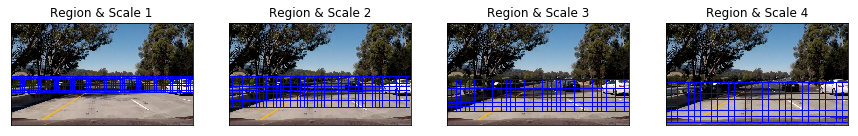

In [6]:
# EDIT CODE & NUMBERS!!

pix_per_cell = 8
orient = 9
cell_per_block = 2

def draw_scale_windows(img, y_start, y_stop, scale):
    output_img = np.copy(img)
    img = img.astype(np.float32) / 255

    img_region = img[y_start:y_stop, :, :]
    imshape = img_region.shape
    img_region = cv2.resize(img_region, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    num_xblocks = (img_region.shape[1] // pix_per_cell) - 1
    num_yblocks = (img_region.shape[0] // pix_per_cell) - 1

    window = 64
    cells_per_step = 2 
    num_blocks_per_window = (window // pix_per_cell) - 1
    num_xsteps = (num_xblocks - num_blocks_per_window) // cells_per_step
    num_ysteps = (num_yblocks - num_blocks_per_window) // cells_per_step

    rect_start = None
    rect_end = None
    for xb in range(num_xsteps+1):
        for yb in range(num_ysteps+1):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            x_box_left = np.int(xleft * scale)
            y_top_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)
            rect_start = (x_box_left, y_top_draw + y_start)
            rect_end = (x_box_left + win_draw, y_top_draw + win_draw + y_start)
            cv2.rectangle(output_img, rect_start, rect_end, (0, 0, 255), 4)
    return output_img


region_and_scales = [((380, 500), 1.0), ((380, 600), 1.5), ((400, 650), 2), ((420, 700), 2.5)]

plt.figure(figsize=(15,40))
plot_count=1
for (region, scale) in region_and_scales:
    y_start, y_stop = region
    plt.subplot(1,4, plot_count)
    plt.imshow(draw_scale_windows(test_img, y_start, y_stop, scale))
    plt.title('Region & Scale %s'% plot_count)
    plt.xticks([])
    plt.yticks([])
    plot_count +=1

### Video processing

In [10]:
from utils import HeatmapBuffer

In [205]:
test_path = 'test_video.mp4'
project_path = 'project_video.mp4'
output_path = 'output_video.mp4'

def gather_frames(path):
    video = cv2.VideoCapture(path)
    frames = []
    while video.isOpened():
        has_frame, frame = video.read()
        if has_frame:
            color_transformed = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(color_transformed)
        else:
            break
    video.release()
    return np.array(frames)

def frames_to_video(frames, path):
    skvideo.io.vwrite(path, frames)

def draw_boxes(frames, heatmaps):
    imgs_with_boxes = frames.copy()
    color = (0, 0, 255)
    thickness = 4
    
    for i, heatmap in tqdm(enumerate(heatmaps)):
        img_with_box = imgs_with_boxes[i]
        labelled, num_cars = label(heatmap)
        for car_idx in range(1, num_cars+1):
            region_y, region_x = np.where(labelled == car_idx)
            box_top_left = (np.min(region_x), np.min(region_y))
            box_bottom_right = (np.max(region_x), np.max(region_y))
            cv2.rectangle(img_with_box, box_top_left, box_bottom_right, color, thickness)
        imgs_with_boxes[i] = img_with_box
            
    return imgs_with_boxes

def threshold_heatmaps(heatmaps, threshold=3, buffer_size=8):
    buffer = HeatmapBuffer((buffer_size,) + heatmaps[0].shape)
    thresholded = list()
    for heatmap in tqdm(heatmaps):
        buffer.add_heatmap(heatmap)
        mean_heatmap = buffer.mean_heatmap()
        heatmap[mean_heatmap < threshold] = 0
        thresholded.append(heatmap)
    return thresholded

def pipeline(frames, svc, scaler, region_and_scales):
    raw_heatmaps = [mark_cars(img, region_and_scales, svc, scaler) for img in tqdm(frames)]
    thresholded_heatmaps = threshold_heatmaps(raw_heatmaps)
    processed_frames = draw_boxes(frames, thresholded_heatmaps)
    return processed_frames

In [206]:
%time frames = gather_frames(project_path)

CPU times: user 12.7 s, sys: 5.63 s, total: 18.3 s
Wall time: 38.9 s


In [ ]:
region_and_scales = [((380, 500), 1.0), ((380, 600), 1.5), ((400, 650), 2), ((400, 700), 2.5)]

In [ ]:
processed_frames = pipeline(frames, loaded_svc, loaded_scaler, region_and_scales) 

  0%|          | 0/1260 [00:00<?, ?it/s]/Users/alex/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
  3%|▎         | 44/1260 [04:26<1:56:34,  5.75s/it]

In [186]:
%time frames_to_video(processed_frames, output_path) 

In [195]:
#frames2 = gather_frames(test_path)
x1 = mark_cars(frames2[0], region_and_scales, loaded_svc, loaded_scaler)
x2 = mark_cars(frames2[1], region_and_scales, loaded_svc, loaded_scaler)
x3 = mark_cars(frames2[2], region_and_scales, loaded_svc, loaded_scaler)
x4 = mark_cars(frames2[3], region_and_scales, loaded_svc, loaded_scaler)
y = threshold_heatmaps((x1,x2,x3,x4))
boxed = draw_boxes(frames[0:4], y)

/Users/alex/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
100%|██████████| 4/4 [00:00<00:00, 60.63it/s]
4it [00:00, 74.27it/s]


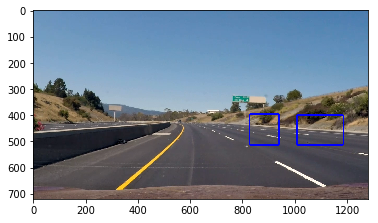

In [196]:
plt.imshow(boxed[3])

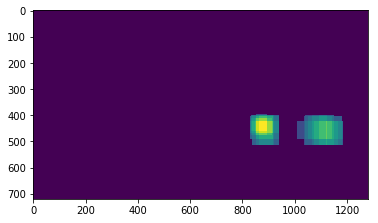

In [197]:
plt.imshow(x4)

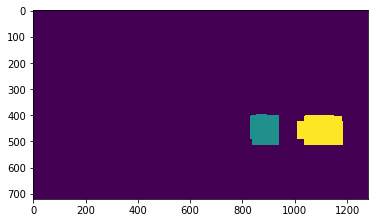

In [199]:
z, _ = label(x4)
plt.imshow(z)